# **Angular correlation of $\mathrm{Q}\overline{\mathrm{Q}}$ pairs produced back-to-back in a Glasma from $\mathrm{Pb}$-$\mathrm{Pb}$@$\mathrm{5.02\,\mathrm{TeV}}$**

# Version 1: toy model
Let's assume a pair is produced at the boundary, for example at $x=0$ with $y\in(0,L)$. If the direction of $\overline{\mathrm{Q}}$ is poiting outside, then the $\mathrm{Q}$ formed with random $\theta_i\in(-\pi/2,\pi/2)$ transverses the Glasma. One is interested in the angle $\Delta\theta=\theta_f-\theta_i$. 

## Default simulation parameters for the Glasma and the Wong solvers

In [1]:
import numpy as np

# hbar * c [GeV * fm]
hbarc = 0.197326 

# Simulation box 
L = 10      
N = 512    
tau_sim = 1.0     
DTS = 8     

# Glasma for Pb-Pb at 5.02 TeV
su_group = 'su3'
A = 207     
sqrts = 5020        
ns = 50     
factor = 0.8        
Qs = np.sqrt(0.13 * A**(1/3) * sqrts**0.25)        
g = np.pi * np.sqrt(1 / np.log(Qs / 0.2))          
mu = Qs / (g**2 * factor)          	
ir = 0.1 * g**2 * mu         
uv = 10.0                     

# Wong
quark = 'charm'    
mass = 1.275      
tau_form = 1/(2*mass)*hbarc     
initialization = 'toy'         
pT = 10.0    
ntp = 10**5  
nevents = 10    
noffset = 0
representation = 'fundamental'      
boundary = 'periodic'       

folder = su_group + '_pT_' + str(pT) + '_' + quark       # Results folder

# Store relevant parameters in a dictionary
p = {
    'QUARK': quark,
    'MASS': mass,           
    'TFORM': tau_form,   
    'NTP':  ntp,    
    'PT': pT,          
    'INIT': initialization,   
    'FOLDER': folder,      
    }

## Set environment variables

In [2]:
import os
os.environ["MY_NUMBA_TARGET"] = "cuda"
os.environ["PRECISION"] = "double"
os.environ["GAUGE_GROUP"] = su_group

# Import relevant modules
import sys
sys.path.append('..')

# Glasma modules
import curraun.core as core
import curraun.mv as mv
import curraun.initial as initial
initial.DEBUG = False

import curraun.su as su
from curraun.numba_target import use_cuda
if use_cuda:
    from numba import cuda

# Wong modules
from curraun import wong
wong.BOUNDARY = boundary
# wong.WONG_TO_HOST = True
from curraun.wong import init_pos, init_charge, init_mom_toy, init_mom_fonll
from curraun.hqs import Angles

Using CUDA
Using SU(3)
Using double precision
Using double precision


## Simulation routine for evolving the Glasma & solving Wong's equations
Quark and antiquark pair initialized at the same position, with opposite momenta and random charge. Momenta $(p^x,p^y,p^z,p^\eta)$ and the ```active``` array, which keeps track of particles which reached the boundary, are stored throughout the evolution.

In [3]:
import pickle
from tqdm import tqdm

def init_mom_toy_in(pT):
    """
        Initialize all particles with the same initial transverse momentum
        but the angle is in (0, pi)
    """
    # angle = np.pi*np.random.rand(1) - np.pi/2
    angle = np.pi*np.random.rand(1)
    p0 = [0.0, pT * np.cos(angle), pT * np.sin(angle), 0.0, 0.0]

    return p0

def init_pos_in(n):

    x = np.random.rand(1) * n
    x0 = [x, 0.0, 0.0]

    return x0

current_path = os.getcwd() 
results_folder = 'results'
if not os.path.isdir(results_folder):
    os.makedirs(results_folder)
results_path = current_path + '/' + results_folder + '/'

def simulate(p, ev): 
    os.chdir(results_path)

    # Derived parameters
    a = L/N
    E0 = N/L * hbarc
    DT = 1.0 / DTS
    formt = int(p['TFORM'] / a * DTS)
    maxt = int(tau_sim / a * DTS)

    # Initialize Glasma fields
    s = core.Simulation(N, DT, g)
    va = mv.wilson(s, mu=mu / E0, m=ir / E0, uv=uv / E0, num_sheets=ns)
    vb = mv.wilson(s, mu=mu / E0, m=ir / E0, uv=uv / E0, num_sheets=ns)
    initial.init(s, va, vb)

    if initialization=='fonll':
        pTs_fonll, ntp_fonll = init_mom_fonll(p)
        ntp = ntp_fonll
        p['NTP'] = ntp_fonll

    if initialization=='toy':
        pT = p['PT'] 
        ntp = p['NTP']

    output = {}
    output['parameters'] = p.copy()

    # Initialize the Wong solver
    wong_solver = wong.WongSolver(s, ntp)
    x0s, p0s, q0s = np.zeros((ntp, 3)), np.zeros((ntp, 5)), np.zeros((ntp, su.ALGEBRA_ELEMENTS))
    masses = mass / E0 * np.ones(ntp)

    for i in range(ntp):
        if initialization=='toy':
            p0 = init_mom_toy_in(pT / E0)   
        elif initialization=='fonll':
            pT = pTs_fonll[i]
            p0 = init_mom_toy_in(pT / E0)
        p0s[i, :] = p0

        x0, q0 = init_pos_in(s.n), init_charge(representation)
        x0s[i, :], q0s[i, :] = x0, q0
    
    wong_solver.initialize(x0s, p0s, q0s, masses)
    qqbar_angle = Angles(wong_solver, ntp)

    angles = np.zeros((maxt-formt, ntp))
    pTs = np.zeros((maxt-formt, ntp))

    with tqdm(total=maxt) as pbar:
        for t in range(maxt):
            # Evolve Glasma fields
            core.evolve_leapfrog(s)

            # Solve Wong's equations
            if t>=formt: 
                qqbar_angle.compute()
                angles[t-formt] = qqbar_angle.angle.copy()
                pTs[t-formt] = qqbar_angle.pT.copy() * E0

                wong_solver.evolve()

            pbar.set_description("Event " + str(ev+1))
            pbar.update(1)

    output['angles'] = angles
    tau = np.linspace(p['TFORM'], tau_sim, maxt-formt)
    output['tau'] = tau
    output['pTs'] = pTs

    init_folder = 'ang_corr_' + p['QUARK'] + '_' + su_group + '_' + str(p['INIT'])
    if not os.path.isdir(init_folder):
        os.makedirs(init_folder)
    init_path = results_path + '/' + init_folder + '/'
    os.chdir(init_path)

    if p['INIT']=='toy':
        wong_folder = p['FOLDER']
        if not os.path.isdir(wong_folder):
            os.makedirs(wong_folder)
        wong_path = init_path + '/' + wong_folder + '/'
        os.chdir(wong_path)

    filename = 'event_' + str(ev+1) + '.pickle'
    with open(filename, 'wb') as handle:
        pickle.dump(output, handle)

    os.chdir(current_path)

## Running the Wong solver over multiple Glasma events

In [16]:
quarks = ['charm', 'beauty']
quark_masses = [1.27, 4.18]
pTs = [0.5, 5.0, 10.0]
formation_times = [0.06, 0.02]
# pTs = np.linspace(6, 8, 11)

for iq in range(len(quarks)):
    print(quarks[iq].capitalize() + " quark")
    p['QUARK'], p['MASS'] = quarks[iq], quark_masses[iq]
    # p['TFORM'] = 1/(2*p['MASS'])*hbarc 
    p['TFORM'] = formation_times[iq]

    if p['INIT']=='toy':
        for pT in pTs:
            print('Transverse momentum', pT, 'GeV')
            p['PT'] = pT
            tag = quarks[iq] + '_pT_' + str(pT)
            p['FOLDER'] = 'pT_' + str(pT)
            for ev in range(noffset, noffset+nevents):
                simulate(p, ev) 
    elif p['INIT']=='fonll':
        for ev in range(noffset, noffset+nevents):
            simulate(p, ev)

os.chdir(current_path)

Charm quark
Transverse momentum 0.5 GeV


Event 11:   6%|▌         | 24/409 [00:05<01:03,  6.07it/s]

## Read data from file and store in dataframe

In [2]:
import pandas as pd  
import numpy as np
import os
import pickle

def find_nearest(array, value):
        array = np.asarray(array)
        index = (np.abs(array - value)).argmin()
        return index

def res_to_df_toy(n_particles, pTs_Q, taus):

    current_path = os.getcwd() 
    results_folder = 'results'
    results_path = current_path + '/' + results_folder + '/'
    path = results_path + 'ang_corr_' + quark + '_' + su_group + '_' + initialization + '/'
    os.chdir(path)

    index_df = 0
    df_array = np.zeros((n_particles*len(taus)*len(pTs_Q), 4))

    for ip, pT_Q in enumerate(pTs_Q):
        ang_corr_folder = 'pT_' + str(pT_Q)
        ang_corr_path = path + ang_corr_folder
        os.chdir(ang_corr_path)

        angles, pTs = [], []
        for i, filename in enumerate(os.listdir(os.getcwd())):
            results = pickle.load(open(filename, 'rb'))
            p = results['parameters']
            angles.append(results['angles'])
            pTs.append(results['pTs'])
            
        angles, pTs = np.array(angles), np.array(pTs)
    
        if ip==0:
            tau = results['tau']
            indices = []
            for t in taus:
                index = find_nearest(tau, t)
                indices.append(index)

        angles_tau, pTs_tau = {}, {}
        for i, t in enumerate(taus):
            angles_tau[str(t)] = angles[:, indices[i], :].reshape(angles.shape[0]*angles.shape[2])
            pTs_tau[str(t)] = pTs[:, indices[i], :].reshape(pTs.shape[0]*pTs.shape[2])

        for i in range(n_particles):
            for j in range(len(taus)):
                df_array[index_df, 0] = pT_Q
                df_array[index_df, 1] = taus[j]
                df_array[index_df, 2] = angles_tau[str(taus[j])][i]
                df_array[index_df, 3] = pTs_tau[str(taus[j])][i]
                index_df += 1

        os.chdir(results_path)
    df = pd.DataFrame(df_array, columns=["pTQ", "tau", "angle", "pTaQ"])  
    os.chdir(current_path)
    return df 

def res_to_df_fonll(n_particles, taus):

    current_path = os.getcwd() 
    results_folder = 'results'
    results_path = current_path + '/' + results_folder + '/'
    path = results_path + 'ang_corr_' + quark + '_' + su_group + '_' + initialization + '/'
    os.chdir(path)

    ntp_fonll = 0
    shapes = []
    for i, filename in enumerate(os.listdir(os.getcwd())):
        results = pickle.load(open(filename, 'rb'))
        p = results['parameters']
        ntp_fonll += p['NTP']
        shape = results['angles'].shape
        
    angles, pTs_Q, pTs_aQ = np.zeros((shape[0], ntp_fonll)), np.zeros((ntp_fonll)), np.zeros((shape[0], ntp_fonll))


    counter = 0
    for i, filename in enumerate(os.listdir(os.getcwd())):
        results = pickle.load(open(filename, 'rb'))
        p = results['parameters']
        ntp = p['NTP']
        angles[:, counter:(counter+ntp)] = results['angles']
        pTs_Q[counter:(counter+ntp)] = results['pTs'][1, :]
        pTs_aQ[:, counter:(counter+ntp)] = results['pTs']
        counter += ntp
        
    tau = results['tau']
    indices = []
    for t in taus:
        index = find_nearest(tau, t)
        indices.append(index)

    angles_tau, pTs_tau = {}, {}
    for i, t in enumerate(taus):
        angles_tau[str(t)] = angles[indices[i], :]
        pTs_tau[str(t)] = pTs_aQ[indices[i], :]

    index_df = 0
    df_array = np.zeros((n_particles*len(taus), 4))
    for i in range(n_particles):
        for j in range(len(taus)):
            df_array[index_df, 0] = pTs_Q[i]
            df_array[index_df, 1] = taus[j]
            df_array[index_df, 2] = angles_tau[str(taus[j])][i]
            df_array[index_df, 3] = pTs_tau[str(taus[j])][i]
            index_df += 1

    os.chdir(results_path)
    df = pd.DataFrame(df_array, columns=["pTQ", "tau", "angle", "pTaQ"])  
    os.chdir(current_path)
    return df 

## FONLL initialization

In [3]:
quark = 'charm'       
initialization = 'fonll'

current_path = os.getcwd() 
os.chdir(current_path)

taus = [0.08, 0.1, 0.3, 0.5]
n_particles = 38*10**5
df = res_to_df_fonll(n_particles, taus)

In [4]:
pT_low, pT_high = 6, 8
df_pTQ_cut = df[df['pTQ'].between(pT_low, pT_high, inclusive=False)]

In [5]:
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import cm
import matplotlib.colors

sns.set(rc={'text.usetex' : True})
sns.set(rc={'figure.figsize':(6, 5)})
sns.set(font_scale = 1.5)

sns.set_style("white")
sns.set_style({"xtick.direction": "in","ytick.direction": "in"})

transparent_white = matplotlib.colors.colorConverter.to_rgba('white',alpha = 0)

norm = matplotlib.colors.Normalize(vmin=0, vmax=1)
colors = [cm.twilight(norm(i)) for i in np.linspace(0, 1, 8)]
colors.insert(0, transparent_white)
custom_cmap = LinearSegmentedColormap.from_list("custom_cmap", colors)

nb_colors = len(taus)
cm_subsection = np.linspace(0, 1, nb_colors) 
cmap_colors = [custom_cmap(x) for x in cm_subsection]
sns.set_palette(cmap_colors)

Text(6, 10.7, '$6\\,\\mathrm{GeV}<p_T^Q<8\\,\\mathrm{GeV}$')

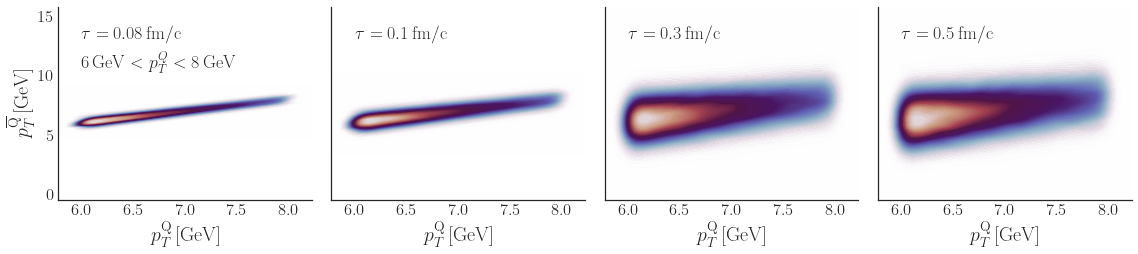

In [6]:
import matplotlib.pyplot as plt

g = sns.FacetGrid(df_pTQ_cut, col="tau", height=4, aspect=1)
g.map(sns.kdeplot, 'pTQ', 'pTaQ', kind='kde', space=0, fill=True, thresh=0, levels=100, cmap=custom_cmap)

g.set_axis_labels(r'$p_T^\mathrm{Q}\,\mathrm{[GeV]}$', r'$p_T^\mathrm{\overline{Q}}\,\mathrm{[GeV]}$', fontsize = 20)
g.set_titles("")

axes = g.axes.flatten()
for i in range(len(taus)):
    axes[i].text(6, 13, r"$\tau=%s\,\mathrm{fm/c}$"%(taus[i]))

text = r"${}\,\mathrm{{GeV}}<p_T^Q<{}\,\mathrm{{GeV}}$".format(str(pT_low), str(pT_high))
axes[0].text(6, 10.7, text)
plt.savefig('plots/pTQ_pTaQ_corr_su3_fonll_init_pTQ_cut_tau_dep.png', dpi=600)

In [9]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

sns.set(font_scale = 1.8)
sns.set_style("white")
sns.set_style({"xtick.direction": "in","ytick.direction": "in"})

jps = []

for itau in range(len(taus)):
    df_tau = df_pTQ_cut[df_pTQ_cut['tau'] == taus[itau]]
    jp1 = sns.jointplot(data=df_tau, x='angle', y='pTaQ', kind='kde', fill=True, thresh=0, levels=500, cmap=custom_cmap, marginal_kws={'alpha': 0.3})
    jps.append(jp1)
    if itau==0:
        jp1.set_axis_labels(r'$\theta\,(^\circ)$', r'$p_T^{\overline{Q}}\,\mathrm{[GeV]}$', fontsize=28)
    else:
        jp1.set_axis_labels(r'$\theta\,(^\circ)$', "", fontsize=28)

    if itau==0:
        text = r"${}\,\mathrm{{GeV}}<p_T^Q<{}\,\mathrm{{GeV}}$".format(str(pT_low), str(pT_high))
        jp1.ax_joint.text(150, 9.5, text)
    jp1.ax_joint.text(150, 10.8, r"$\tau=%s\,\mathrm{fm/c}$"%(taus[itau]))

    jp1.ax_marg_x.set_xlim(145, 215)
    jp1.ax_marg_x.set_xticks([150, 180, 210])
    jp1.ax_marg_y.set_ylim(2.3, 11.7)
    jp1.ax_marg_y.set_yticks([4, 6, 8, 10])

for j, jp in enumerate(jps):
    jp.savefig('jp_fonll_' + str(j) + '.png', dpi=600)
    plt.close(jp.fig)

fig, axes = plt.subplots(1, len(taus), figsize=(4*len(taus), 4))

index = 0
for itau in range(len(taus)):
    axes[itau].imshow(mpimg.imread('jp_fonll_' + str(index) + '.png'))
    index += 1

[ax.set_axis_off() for ax in axes.ravel()]
plt.tight_layout(pad=0)

plt.show()
# fig.savefig('plots/pTaQ_angle_corr_su3_fonll_init_pTQ_cut_tau_dep.png', dpi=600)

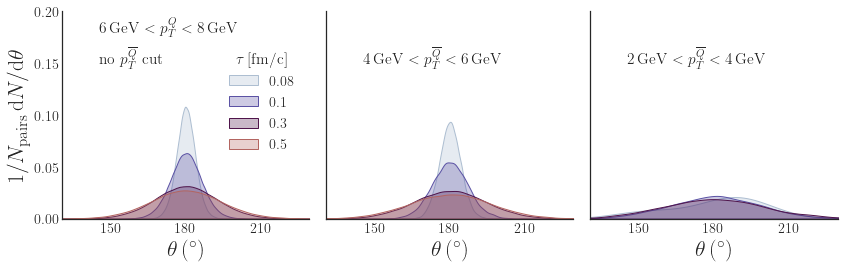

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors
from matplotlib.colors import LinearSegmentedColormap

nb_colors = len(taus)+2
cm_subsection = np.linspace(0, 1, nb_colors) 
cmap_colors = [custom_cmap(x) for x in cm_subsection]
custom_palette = sns.color_palette(cmap_colors[1:(len(cmap_colors)-1)])
sns.set_palette(custom_palette)

sns.set(rc={'text.usetex' : True})
sns.set(font_scale = 1.3)
sns.set_style("white")
sns.set_style({"xtick.direction": "in","ytick.direction": "in"})
sns.set_palette(custom_palette)

fig, axes = plt.subplots(figsize=(12, 4), ncols=3, nrows=1, sharey='row')
pT_cuts = np.array([[], [4, 6], [2, 4]])


for i in range(3):
    if i==0:
        for k in range(len(taus)):
            df_tau = df_pTQ_cut[df_pTQ_cut['tau'] == taus[k]]
            sns.kdeplot(df_tau["angle"], shade=True, alpha=0.3, linewidth=1, label=r"$%s$"%(taus[k]), ax=axes[i])

        pT_low, pT_high = 6, 8
        axes[i].text(145, 0.18, r"${}\,\mathrm{{GeV}}<p_T^Q<{}\,\mathrm{{GeV}}$".format(str(pT_low), str(pT_high)))
        axes[i].text(145, 0.15, r'$\mathrm{no}\,\,p_T^{\overline{Q}}\,\,\mathrm{cut}$')
    else:
        for k in range(len(taus)):
            pT_low, pT_high = pT_cuts[i][0], pT_cuts[i][1]
            df_tau = df_pTQ_cut[df_pTQ_cut['tau'] == taus[k]]
            df_pTQ_pTaQ_cut = df_tau[df_tau['pTaQ'].between(pT_low, pT_high, inclusive=False)]
            sns.kdeplot(df_pTQ_pTaQ_cut["angle"], shade=True, alpha=0.3, linewidth=1, label=r"$%s$"%(taus[k]), ax=axes[i])

        text = r"${}\,\mathrm{{GeV}}<p_T^{{\overline{{Q}}}}<{}\,\mathrm{{GeV}}$".format(str(pT_low), str(pT_high))
        axes[i].text(145, 0.15, text)

    if i==0:
        axes[i].set_ylabel(r'$1/N_\mathrm{pairs}\,\mathrm{d}N/\mathrm{d}\theta$', fontsize = 22)
    axes[i].set_xlabel(r'$\theta\,(^\circ)$', fontsize = 22)
    axes[i].set_xlim(130, 230)
    axes[i].set_xticks([150, 180, 210])
    axes[i].set_ylim(0, 0.2)

axes[0].legend(loc='upper right', bbox_to_anchor=(0.99, 0.87), frameon=False, title=r'$\tau\,\mathrm{[fm/c]}$')
sns.despine()

plt.tight_layout()
fig.savefig('Npairs_angle_corr_su3_fonll_init_tau_pTQ_dep_pTaQ_cuts.png', dpi=600)

## Toy model initialization

In [5]:
current_path = os.getcwd() 
os.chdir(current_path)

pTs_Q = [0.5, 5, 10]
taus = [0.08, 0.1, 0.3, 0.5]
n_particles = 10*10**5

df = res_to_df_toy(n_particles, pTs_Q, taus)

In [10]:
import seaborn as sns
import matplotlib.colors
from matplotlib.colors import LinearSegmentedColormap

sns.set(rc={'text.usetex' : True})
sns.set(rc={'figure.figsize':(6, 5)})
sns.set(font_scale = 1.5)

sns.set_style("ticks")
sns.set_style({"xtick.direction": "in","ytick.direction": "in"})

transparent_white = matplotlib.colors.colorConverter.to_rgba('white',alpha = 0)
colors = ["#DA8042", "#E2AB4A", "#E1C45E", "#C8C198", "#BBC0E1", transparent_white]
custom_cmap = LinearSegmentedColormap.from_list("custom_cmap", colors[::-1])

nb_colors = len(taus)
cm_subsection = np.linspace(0, 1, nb_colors) 
cmap_colors = [custom_cmap(x) for x in cm_subsection]
sns.set_palette(sns.color_palette(cmap_colors))

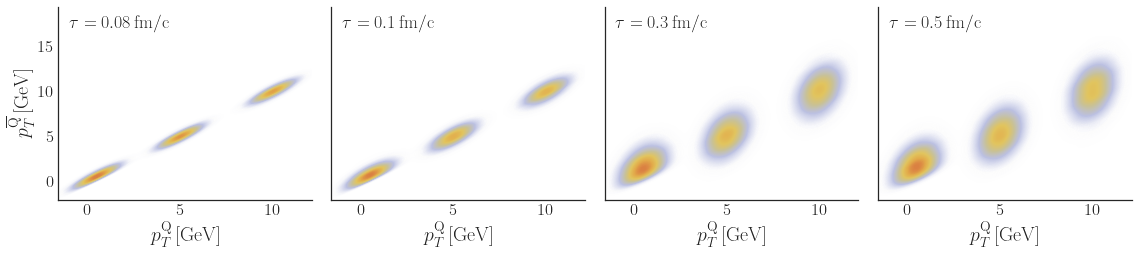

In [7]:
import matplotlib.pyplot as plt

sns.set(font_scale = 1.5)
sns.set_style("white")
sns.set_style({"xtick.direction": "in","ytick.direction": "in"})
plt.rcParams['xtick.major.size'] = 4
plt.rcParams['ytick.major.size'] = 4

g = sns.FacetGrid(df, col="tau", height=4, aspect=1)
g.map(sns.kdeplot, 'pTQ', 'pTaQ', kind='kde', space=0, fill=True, thresh=0, levels=300, cmap=custom_cmap)

g.set_axis_labels(r'$p_T^\mathrm{Q}\,\mathrm{[GeV]}$', r'$p_T^\mathrm{\overline{Q}}\,\mathrm{[GeV]}$', fontsize = 20)
g.set_titles("")

axes = g.axes.flatten()
for i in range(len(taus)):
    axes[i].text(-1, 17, r"$\tau=%s\,\mathrm{fm/c}$"%(taus[i]))

plt.savefig('pTQ_pTaQ_corr_su3_toy_init_tau_dep.png', dpi=600)

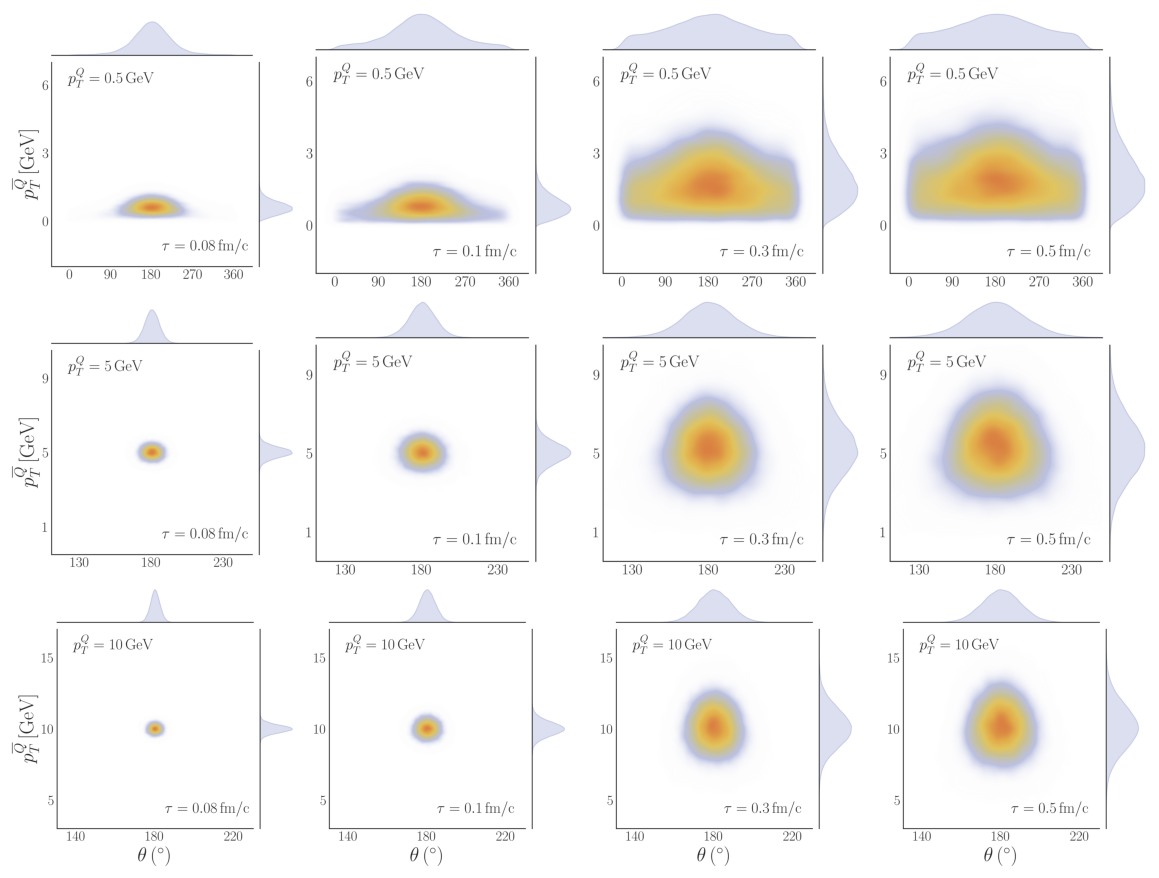

In [11]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

sns.set(font_scale = 1.8)
sns.set_style("white")
sns.set_style({"xtick.direction": "in","ytick.direction": "in"})
palette_colors = ["#DA8042", "#E2AB4A", "#E1C45E", "#C8C198", "#BBC0E1"]
sns.set_palette(sns.color_palette(palette_colors[::-1]))

jps = []

# su2
# pT_lims = [[-0.9, 3.9], [1.5, 8.5], [7, 13]]
# deg = 180
# delta_degs = [220, 50, 30]
# theta_ticks = [[0, 90, 180, 270, 360], [150, 180, 210], [160, 180, 200]]
# pT_ticks = [[0, 1, 2, 3], [3, 5, 7], [8, 10, 12]]
# su3
pT_lims = [[-2, 7], [-0.5, 10.5], [3, 17]]
deg = 180
delta_degs = [220, 70, 50]
theta_ticks = [[0, 90, 180, 270, 360], [130, 180, 230], [140, 180, 220]]
pT_ticks = [[0, 3, 6], [1, 5, 9], [5, 10, 15]]

for ipTQ in range(len(pTs_Q)):
    for itau in range(len(taus)):
        df_tau = df[df['tau'] == taus[itau]]
        df_tau_pTQ = df_tau[df_tau['pTQ'] == pTs_Q[ipTQ]]
        jp1 = sns.jointplot(data=df_tau_pTQ, x='angle', y='pTaQ', kind='kde', fill=True, thresh=0, levels=300, cmap=custom_cmap, marginal_kws={'alpha': 0.5})
        jps.append(jp1)
        if itau==0 and ipTQ==(len(pTs_Q)-1):
            jp1.set_axis_labels(r'$\theta\,(^\circ)$', r'$p_T^{\overline{Q}}\,\mathrm{[GeV]}$', fontsize=28)
        elif itau==0:
            jp1.set_axis_labels("", r'$p_T^{\overline{Q}}\,\mathrm{[GeV]}$', fontsize=28)
        elif ipTQ==(len(pTs_Q)-1):
            jp1.set_axis_labels(r'$\theta\,(^\circ)$', "", fontsize=28)
        else:
            jp1.set_axis_labels("", "", fontsize=28)

        jp1.ax_joint.text(deg-delta_degs[ipTQ]+8/100*2*delta_degs[ipTQ], pT_lims[ipTQ][0]+90/100*(pT_lims[ipTQ][1]-pT_lims[ipTQ][0]), r"$p_T^Q=%s\,\mathrm{GeV}$"%(pTs_Q[ipTQ]))
        jp1.ax_joint.text(deg-delta_degs[ipTQ]+55/100*2*delta_degs[ipTQ], pT_lims[ipTQ][0]+8/100*(pT_lims[ipTQ][1]-pT_lims[ipTQ][0]), r"$\tau=%s\,\mathrm{fm/c}$"%(taus[itau]))

        jp1.ax_marg_x.set_xlim(deg-delta_degs[ipTQ], deg+delta_degs[ipTQ])
        jp1.ax_marg_x.set_xticks(theta_ticks[ipTQ])
        jp1.ax_marg_y.set_ylim(pT_lims[ipTQ][0], pT_lims[ipTQ][1])
        jp1.ax_marg_y.set_yticks(pT_ticks[ipTQ])

for j, jp in enumerate(jps):
    jp.savefig('jp_' + str(j) + '.png', dpi=600)
    plt.close(jp.fig)

fig, axes = plt.subplots(len(pTs_Q), len(taus), figsize=(4*len(taus), 4*len(pTs_Q)))

index = 0
for ipTQ in range(len(pTs_Q)):
    for itau in range(len(taus)):
        axes[ipTQ, itau].imshow(mpimg.imread('jp_' + str(index) + '.png'))
        index += 1

[ax.set_axis_off() for ax in axes.ravel()]
plt.tight_layout(pad=0)

plt.show()
# fig.savefig('pTaQ_angle_corr_su3_toy_init_tau_pTQ_dep.png', dpi=600)

In [23]:
os.chdir(current_path)

pTs_Q = [0.5, 5, 10]
taus = [0.08, 0.1, 0.3, 0.5]
n_particles = 10**5

df = res_to_df_toy(n_particles, pTs_Q, taus)

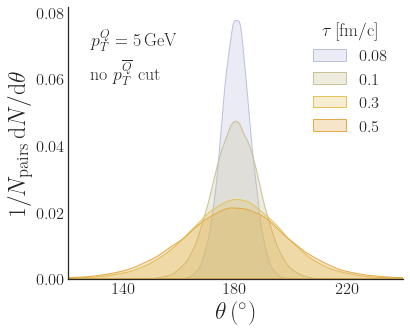

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors
from matplotlib.colors import LinearSegmentedColormap

sns.set(rc={'text.usetex' : True})
sns.set(rc={'figure.figsize':(6, 5)})
sns.set(font_scale = 1.5)

plt.rcParams.update({"text.usetex": True})

sns.set_style("white")
sns.set_style({"xtick.direction": "in","ytick.direction": "in"})

transparent_white = matplotlib.colors.colorConverter.to_rgba('white',alpha = 0)
colors = ["#DA8042", "#E2AB4A", "#E1C45E", "#C8C198", "#BBC0E1", transparent_white]
custom_cmap = LinearSegmentedColormap.from_list("custom_cmap", colors[::-1])

nb_colors = len(taus)+2
cm_subsection = np.linspace(0, 1, nb_colors) 
cmap_colors = [custom_cmap(x) for x in cm_subsection]
custom_palette = sns.color_palette(cmap_colors[1:(len(cmap_colors)-1)])
sns.set_palette(custom_palette)

pT_low, pT_high = 0, 20

for i in range(len(taus)):
    df_tau = df[df['tau'] == taus[i]]
    df_pTQ_cut = df_tau[df_tau['pTQ']==5]
    df_pTQ_pTaQ_cut = df_pTQ_cut[df_pTQ_cut['pTaQ'].between(pT_low, pT_high, inclusive=False)]
    ax = sns.kdeplot(df_pTQ_pTaQ_cut["angle"], shade=True, alpha=0.3, linewidth=1, label=r"$%s$"%(taus[i]))
plt.legend(frameon=False, title=r'$\tau\,\mathrm{[fm/c]}$')

ax.set_xlabel(r'$\theta\,(^\circ)$', fontsize = 24)
ax.set_ylabel(r'$1/N_\mathrm{pairs}\,\mathrm{d}N/\mathrm{d}\theta$', fontsize = 24)
ax.set_xlim(120, 240)
ax.set_xticks([140, 180, 220])
ax.text(128, 0.07, r'$p_T^Q=5\,\mathrm{GeV}$')
ax.text(128, 0.06, r'$\mathrm{no}\,\,p_T^{\overline{Q}}\,\,\mathrm{cut}$')
sns.despine()

fig.savefig('Npairs_angle_corr_pTQ_5_su3_toy_init_tau_dep.png', dpi=600)

In [5]:
os.chdir(current_path)

pTs_Q = [0.5, 5, 10]
taus = [0.08, 0.1, 0.3, 0.5]
n_particles = 20*10**5

df = res_to_df_toy(n_particles, pTs_Q, taus)

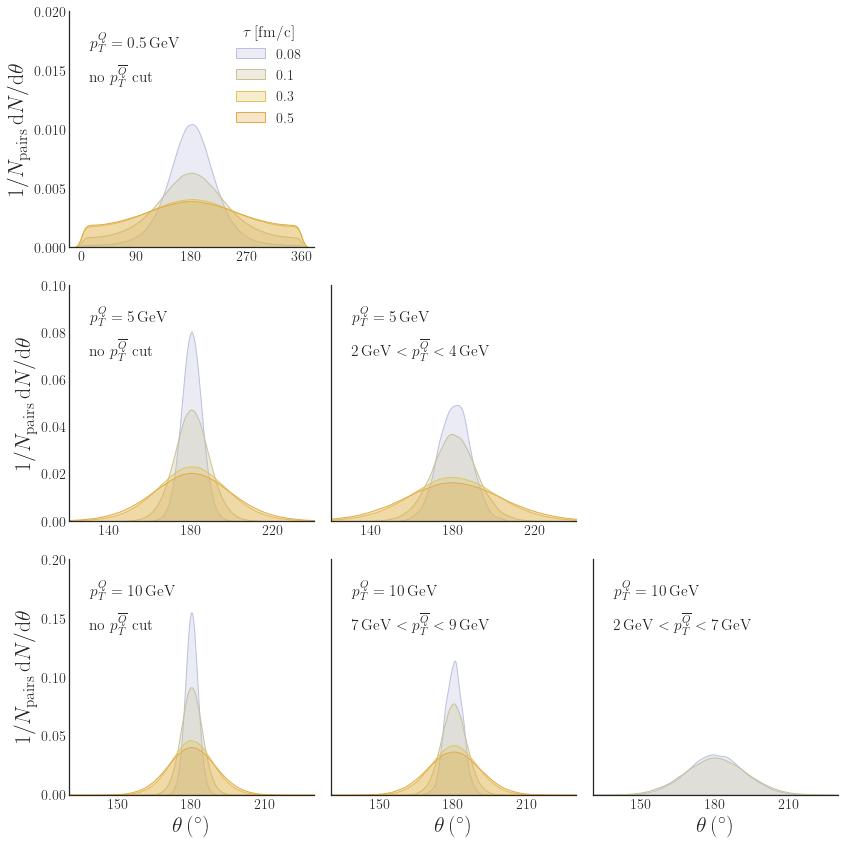

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors
from matplotlib.colors import LinearSegmentedColormap

transparent_white = matplotlib.colors.colorConverter.to_rgba('white',alpha = 0)
colors = ["#DA8042", "#E2AB4A", "#E1C45E", "#C8C198", "#BBC0E1", transparent_white]
custom_cmap = LinearSegmentedColormap.from_list("custom_cmap", colors[::-1])

nb_colors = len(taus)+2
cm_subsection = np.linspace(0, 1, nb_colors) 
cmap_colors = [custom_cmap(x) for x in cm_subsection]
custom_palette = sns.color_palette(cmap_colors[1:(len(cmap_colors)-1)])
sns.set_palette(custom_palette)

sns.set(rc={'text.usetex' : True})
sns.set(font_scale = 1.3)
sns.set_style("white")
sns.set_style({"xtick.direction": "in","ytick.direction": "in"})
sns.set_palette(custom_palette)

fig, axes = plt.subplots(figsize=(12, 12), ncols=3, nrows=3, sharey='row')
count = 0
theta_limits = np.array([[[-20, 380],[] ,[]], [[120,240] ,[120,240] ,[]], [[130, 230] ,[130, 230] ,[130, 230]]])
dens_limits = np.array([[[0, 0.02],[] ,[]], [[0, 0.1] ,[0, 0.1] ,[]], [[0, 0.2] ,[0, 0.2] ,[0, 0.2]]])
theta_ticks = np.array([[[0, 90, 180, 270, 360],[] ,[]], [[140, 180, 220] ,[140, 180, 220] ,[]], [[150, 180, 210] ,[150, 180, 210] ,[150, 180, 210]]])
pT_cuts = np.array([[[],[] ,[]], [[] ,[2, 4] ,[]], [[] ,[7, 9] ,[2, 7]]])


for i in range(3):
    for j in range(3):
        if i<j:
            axes[i, j].axis('off')
        elif j==0:
            for k in range(len(taus)):
                df_tau = df[df['tau'] == taus[k]]
                df_pTQ_cut = df_tau[df_tau['pTQ']==pTs_Q[i]]
                sns.kdeplot(df_pTQ_cut["angle"], shade=True, alpha=0.3, linewidth=1, label=r"$%s$"%(taus[k]), ax=axes[i, j])

            axes[i, j].set_xlim(theta_limits[i,j][0], theta_limits[i,j][1])
            axes[i, j].set_xticks(theta_ticks[i,j])

            axes[i, j].set_ylim(dens_limits[i,j][0], dens_limits[i,j][1])
            axes[i, j].text(theta_limits[i, j][0]+8/100*(theta_limits[i, j][1]-theta_limits[i, j][0]), dens_limits[i, j][0]+85/100*(dens_limits[i, j][1]-dens_limits[i, j][0]), r"$p_T^Q=%s\,\mathrm{GeV}$"%(pTs_Q[i]))
            axes[i, j].text(theta_limits[i, j][0]+8/100*(theta_limits[i, j][1]-theta_limits[i, j][0]), dens_limits[i, j][0]+70/100*(dens_limits[i, j][1]-dens_limits[i, j][0]), r'$\mathrm{no}\,\,p_T^{\overline{Q}}\,\,\mathrm{cut}$')
        else:
            for k in range(len(taus)):
                pT_low, pT_high = pT_cuts[i, j][0], pT_cuts[i, j][1]
                df_tau = df[df['tau'] == taus[k]]
                df_pTQ_cut = df_tau[df_tau['pTQ']==pTs_Q[i]]
                df_pTQ_pTaQ_cut = df_pTQ_cut[df_pTQ_cut['pTaQ'].between(pT_low, pT_high, inclusive=False)]
                sns.kdeplot(df_pTQ_pTaQ_cut["angle"], shade=True, alpha=0.3, linewidth=1, label=r"$%s$"%(taus[k]), ax=axes[i, j])

            text = r"${}\,\mathrm{{GeV}}<p_T^{{\overline{{Q}}}}<{}\,\mathrm{{GeV}}$".format(str(pT_low), str(pT_high))
            axes[i, j].text(theta_limits[i, j][0]+8/100*(theta_limits[i, j][1]-theta_limits[i, j][0]), dens_limits[i, j][0]+70/100*(dens_limits[i, j][1]-dens_limits[i, j][0]), text)


            axes[i, j].set_xlim(theta_limits[i,j][0], theta_limits[i,j][1])
            axes[i, j].set_xticks(theta_ticks[i,j])

            axes[i, j].text(theta_limits[i, j][0]+8/100*(theta_limits[i, j][1]-theta_limits[i, j][0]), dens_limits[i, j][0]+85/100*(dens_limits[i, j][1]-dens_limits[i, j][0]), r"$p_T^Q=%s\,\mathrm{GeV}$"%(pTs_Q[i]))
        if i==2:
            axes[i, j].set_xlabel(r'$\theta\,(^\circ)$', fontsize = 22)
        else:
            axes[i, j].set_xlabel("")
        if j==0:
            axes[i, j].set_ylabel(r'$1/N_\mathrm{pairs}\,\mathrm{d}N/\mathrm{d}\theta$', fontsize = 22)
            if i==0:
                axes[i, j].set_yticks([0, 0.005, 0.01, 0.015, 0.02])
            elif i==2:
                axes[i, j].set_yticks([0, 0.05, 0.1, 0.15, 0.2])
        else:
            axes[i, j].set_ylabel("")

axes[0, 0].legend(frameon=False, title=r'$\tau\,\mathrm{[fm/c]}$')
sns.despine()

plt.tight_layout()
# fig.savefig('toy_dNdangle_angle_su3.png', dpi=600)

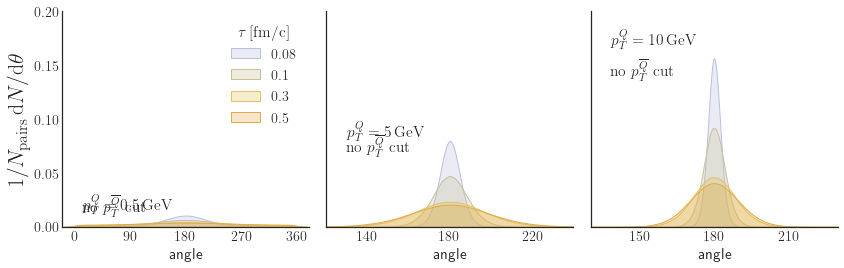

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors
from matplotlib.colors import LinearSegmentedColormap

transparent_white = matplotlib.colors.colorConverter.to_rgba('white',alpha = 0)
colors = ["#DA8042", "#E2AB4A", "#E1C45E", "#C8C198", "#BBC0E1", transparent_white]
custom_cmap = LinearSegmentedColormap.from_list("custom_cmap", colors[::-1])

nb_colors = len(taus)+2
cm_subsection = np.linspace(0, 1, nb_colors) 
cmap_colors = [custom_cmap(x) for x in cm_subsection]
custom_palette = sns.color_palette(cmap_colors[1:(len(cmap_colors)-1)])
sns.set_palette(custom_palette)

sns.set(rc={'text.usetex' : True})
sns.set(font_scale = 1.3)
sns.set_style("white")
sns.set_style({"xtick.direction": "in","ytick.direction": "in"})
sns.set_palette(custom_palette)

fig, axes = plt.subplots(figsize=(12, 4), ncols=3, nrows=1, sharey='row')
count = 0
theta_limits = np.array([[-20, 380], [120,240], [130, 230]])
dens_limits = np.array([[0, 0.02], [0, 0.1], [0, 0.2]])
theta_ticks = np.array([[0, 90, 180, 270, 360] ,[140, 180, 220] ,[150, 180, 210]])
# pT_cuts = np.array([[[],[] ,[]], [[] ,[2, 4] ,[]], [[] ,[7, 9] ,[2, 7]]])


for j in range(3):
    # if j==0:
    for k in range(len(taus)):
        df_tau = df[df['tau'] == taus[k]]
        df_pTQ_cut = df_tau[df_tau['pTQ']==pTs_Q[j]]
        sns.kdeplot(df_pTQ_cut["angle"], shade=True, alpha=0.3, linewidth=1, label=r"$%s$"%(taus[k]), ax=axes[j])

    axes[j].set_xlim(theta_limits[j][0], theta_limits[j][1])
    axes[j].set_xticks(theta_ticks[j])

    axes[j].text(theta_limits[j][0]+8/100*(theta_limits[j][1]-theta_limits[j][0]), dens_limits[j][0]+85/100*(dens_limits[j][1]-dens_limits[j][0]), r"$p_T^Q=%s\,\mathrm{GeV}$"%(pTs_Q[j]))
    axes[j].text(theta_limits[j][0]+8/100*(theta_limits[j][1]-theta_limits[j][0]), dens_limits[j][0]+70/100*(dens_limits[j][1]-dens_limits[j][0]), r'$\mathrm{no}\,\,p_T^{\overline{Q}}\,\,\mathrm{cut}$')
    # else:
    #     for k in range(len(taus)):
    #         pT_low, pT_high = pT_cuts[i, j][0], pT_cuts[i, j][1]
    #         df_tau = df[df['tau'] == taus[k]]
    #         df_pTQ_cut = df_tau[df_tau['pTQ']==pTs_Q[i]]
    #         df_pTQ_pTaQ_cut = df_pTQ_cut[df_pTQ_cut['pTaQ'].between(pT_low, pT_high, inclusive=False)]
    #         sns.kdeplot(df_pTQ_pTaQ_cut["angle"], shade=True, alpha=0.3, linewidth=1, label=r"$%s$"%(taus[k]), ax=axes[j])

    #     text = r"${}\,\mathrm{{GeV}}<p_T^{{\overline{{Q}}}}<{}\,\mathrm{{GeV}}$".format(str(pT_low), str(pT_high))
    #     axes[j].text(theta_limits[i, j][0]+8/100*(theta_limits[i, j][1]-theta_limits[i, j][0]), dens_limits[i, j][0]+70/100*(dens_limits[i, j][1]-dens_limits[i, j][0]), text)


    # axes[j].set_xlim(theta_limits[j][0], theta_limits[j][1])
    # axes[j].set_xticks(theta_ticks[j])

    #     axes[j].text(theta_limits[i, j][0]+8/100*(theta_limits[i, j][1]-theta_limits[i, j][0]), dens_limits[i, j][0]+85/100*(dens_limits[i, j][1]-dens_limits[i, j][0]), r"$p_T^Q=%s\,\mathrm{GeV}$"%(pTs_Q[i]))
    if j==0:
        axes[j].set_ylabel(r'$1/N_\mathrm{pairs}\,\mathrm{d}N/\mathrm{d}\theta$', fontsize = 22)
    else:
        axes[j].set_ylabel("")
    axes[j].set_ylim(dens_limits[j][0], dens_limits[j][1])

axes[0].legend(frameon=False, title=r'$\tau\,\mathrm{[fm/c]}$')
sns.despine()

plt.tight_layout()

# Version 0: naive
All pairs are produced randomly in the transverse plane, when a particles reaches the boundary, its dinamycs is frozen.

## Default simulation parameters for the Glasma and the Wong solvers

In [ ]:
import numpy as np

# hbar * c [GeV * fm]
hbarc = 0.197326 

# Simulation box 
L = 10      
N = 512    
tau_sim = 1.0     
DTS = 8     

# Glasma for Pb-Pb at 5.02 TeV
su_group = 'su3'
A = 207     
sqrts = 5020        
ns = 50     
factor = 0.8        
Qs = np.sqrt(0.13 * A**(1/3) * sqrts**0.25)        
g = np.pi * np.sqrt(1 / np.log(Qs / 0.2))          
mu = Qs / (g**2 * factor)          	
ir = 0.1 * g**2 * mu         
uv = 10.0                     

# Wong
quark = 'charm'    
mass = 1.275      
tau_form = 1/(2*mass)*hbarc     
initialization = 'toy'         
pT = 0    
ntp = 10*5  
nevents = 1    
representation = 'fundamental'      
boundary = 'frozen'       

folder = su_group + '_pT_' + str(pT) + '_' + quark       # Results folder

# Store relevant parameters in a dictionary
p = {
    'QUARK': quark,
    'MASS': mass,           
    'TFORM': tau_form,   
    'NTP':  ntp,    
    'PT': pT,          
    'FOLDER': folder,         
    }

## Set environment variables

In [ ]:
import os
os.environ["MY_NUMBA_TARGET"] = "cuda"
os.environ["PRECISION"] = "double"
os.environ["GAUGE_GROUP"] = su_group

# Import relevant modules
import sys
sys.path.append('..')

# Glasma modules
import curraun.core as core
import curraun.mv as mv
import curraun.initial as initial
initial.DEBUG = False

import curraun.su as su
from curraun.numba_target import use_cuda
if use_cuda:
    from numba import cuda

# Wong modules
from curraun import wong
wong.BOUNDARY = boundary
wong.WONG_TO_HOST = True
from curraun.wong import init_pos, init_charge, init_mom_toy, init_mom_fonll

## Simulation routine for evolving the Glasma & solving Wong's equations
Quark and antiquark pair initialized at the same position, with opposite momenta and random charge. Momenta $(p^x,p^y,p^z,p^\eta)$ and the ```active``` array, which keeps track of particles which reached the boundary, are stored throughout the evolution.

In [ ]:
import pickle
from tqdm import tqdm

current_path = os.getcwd() 
results_folder = 'results'
if not os.path.isdir(results_folder):
    os.makedirs(results_folder)
results_path = current_path + '/' + results_folder + '/'

def simulate(p, ev): 
    os.chdir(results_path)

    output = {}
    output['parameters'] = p.copy()

    # Derived parameters
    a = L/N
    E0 = N/L * hbarc
    DT = 1.0 / DTS
    formt = int(p['TFORM'] / a * DTS)
    maxt = int(tau_sim / a * DTS)

    # Initialize Glasma fields
    s = core.Simulation(N, DT, g)
    va = mv.wilson(s, mu=mu / E0, m=ir / E0, uv=uv / E0, num_sheets=ns)
    vb = mv.wilson(s, mu=mu / E0, m=ir / E0, uv=uv / E0, num_sheets=ns)
    initial.init(s, va, vb)

    if initialization=='fonll':
        pTs_fonll, ntp_fonll = init_mom_fonll(p)
        ntp = ntp_fonll

    if initialization=='toy':
        pT = p['PT'] / E0
        ntp = p['NTP']

    # Initialize the Wong solver
    wong_solver_q = wong.WongSolver(s, ntp)
    wong_solver_aq = wong.WongSolver(s, ntp)
    x0s_q, p0s_q, q0s_q = np.zeros((ntp, 3)), np.zeros((ntp, 5)), np.zeros((ntp, su.ALGEBRA_ELEMENTS))
    x0s_aq, p0s_aq, q0s_aq = np.zeros((ntp, 3)), np.zeros((ntp, 5)), np.zeros((ntp, su.ALGEBRA_ELEMENTS))
    masses = mass / E0 * np.ones(ntp)

    for i in range(ntp):
        if initialization=='toy':
            p0_q = init_mom_toy('pT', pT / E0)            
        elif initialization=='fonll':
            pT_q = pTs_fonll[i] / E0
            p0_q = init_mom_toy('pT', pT_q / E0)
        p0_aq = [-p for p in p0_q]
        p0s_q[i, :], p0s_aq[i, :] = p0_q, p0_aq

        x0_q, q0_q = init_pos(s.n), init_charge(representation)
        x0s_q[i, :], q0s_q[i, :] = x0_q, q0_q
        x0_aq, q0_aq = x0_q, init_charge(representation)
        x0s_aq[i, :], q0s_aq[i, :] = x0_aq, q0_aq
    
    wong_solver_q.initialize(x0s_q, p0s_q, q0s_q, masses)
    wong_solver_aq.initialize(x0s_aq, p0s_aq, q0s_aq, masses)

    p_q, p_aq = np.zeros((maxt-formt, ntp, 4)), np.zeros((maxt-formt, ntp, 4))
    active_q, active_aq = np.zeros((maxt-formt, ntp)), np.zeros((maxt-formt, ntp))

    with tqdm(total=maxt) as pbar:
        for t in range(maxt):
            # Evolve Glasma fields
            core.evolve_leapfrog(s)

            # Solve Wong's equations
            if t>=formt:  
                wong_solver_q.evolve()
                pmu_q = wong_solver_q.p.copy()
                p_q[t-formt] = pmu_q[:, 1:5]
                # print('p=',p_q[t-formt])
                active_q[t-formt] = wong_solver_q.active.copy()
                # print('active=', active_q[t-formt])
                indices = np.argwhere(active_q[t-formt] == 0)
                if indices.size!=0:
                    print('t=', t)
                    print('Quark')
                    print('indices=', indices)
                    print('p_indices=', p_q[t-formt][indices])

                wong_solver_aq.evolve()
                pmu_aq = wong_solver_aq.p.copy()
                p_aq[t-formt] = pmu_aq[:, 1:5]
                # print('p=',p_aq[t-formt])
                active_aq[t-formt] = wong_solver_aq.active.copy()
                # print('active=', active_aq[t-formt])
                # indices = np.where(active_aq[t-formt] == 0)[0]
                # if indices:
                #     print('t=', t)
                #     print('Antiquark')
                #     print('indices=', indices)
                #     print('p_indices=', p_aq[t-formt][indices])

            pbar.set_description("Event " + str(ev+1))
            pbar.update(1)

    output['p_q'], output['p_aq'] = p_q, p_aq
    output['active_q'], output['active_aq'] = active_q, active_aq

    tau = np.linspace(p['TFORM'], tau_sim, maxt-formt)
    output['tau'] = tau

    wong_folder = p['FOLDER']
    if not os.path.isdir(wong_folder):
        os.makedirs(wong_folder)
    wong_path = results_path + '/' + wong_folder + '/'
    os.chdir(wong_path)

    filename = 'event_' + str(ev+1) + '.pickle'
    with open(filename, 'wb') as handle:
        pickle.dump(output, handle)
    # return output

## Running the Wong solver over multiple Glasma events

In [ ]:
# quarks = ['charm', 'beauty']
# quark_masses = [1.27, 4.18]
# pTs = [0.5, 5.0, 10.0]
quarks = ['charm']
quark_masses = [1.27]
pTs = [10.0]
# formation_times = [0.02, 0.08]

for iq in range(len(quarks)):
    print(quarks[iq].capitalize() + " quark")
    p['QUARK'], p['MASS'] = quarks[iq], quark_masses[iq]
    p['TFORM'] = 1/(2*p['MASS'])*hbarc 
    # p['TFORM'] = formation_times[iq]

    for pT in pTs:
        print('Transverse momentum', pT, 'GeV')
        p['PT'] = pT
        tag = quarks[iq] + '_pT_' + str(pT)
        p['FOLDER'] = 'ang_corr_' + su_group + '_toy_pT_' + str(pT) + '_' + quarks[iq] 

        for ev in range(nevents):
            simulate(p, ev)